# NFL Analytics

For as long as I've been watching football, I have wanted to figure out how those statistics that pop up in the corner are calculated. My current understanding is that it takes lots and LOTS of data, most of which is currently inaccessible to me. I still decided to venture into this unknown world by training my model on past official data from the NFL, which is accessible as a python library thanks to the `nfl_data_py` import. This is all being done in hopes to be able to predict the `Win Probability` of either team throughout the game. I'll be going over more details of the code as we progress down the notebook.

In [2]:
import nfl_data_py as nfl

import pandas as pd
import numpy as np

import plotly.graph_objects as go

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

After some trial and error, I'd decided to go with a Random Forest Regression model, almost emulating the seemingly random paths a football game can go down. The learning will done by using the `scikit-learn` library.

I'll be training this model on 3 years worth of data, a number that seemed somewhat reasonable in terms of team/QB composition over that time. Each of the data points I've loaded in the `columns` parameter are the "features", or notable variables, that the model will use to make a connection to the predicted win percentage.

In [3]:
# define the seasons I want to load
desired_seasons = [2021, 2022, 2023]

# load play-by-play data using nfl_data_py
df = nfl.import_pbp_data(
    years=desired_seasons,
    columns=[
        'game_id',
        'posteam',
        'defteam',
        'home_team',
        'away_team',
        'posteam_score',
        'defteam_score',
        'yardline_100',
        'game_date',
        'quarter_seconds_remaining',
        'game_seconds_remaining',
        'down',
        'wp',
        'score_differential',
        'ydstogo',
    ]
)

# inspect the shape of the data
print(df.shape)

2021 done.
2022 done.
2023 done.
Downcasting floats.
(149021, 36)


In [4]:
# look at some random plays
df.sample(5)

,game_id,posteam,defteam,home_team,away_team,posteam_score,defteam_score,yardline_100,game_date,quarter_seconds_remaining,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
15211,2021_06_KC_WAS,WAS,KC,WAS,KC,3.0,7.0,88.0,2021-10-17,837.0,...,00-0032009;00-0031095;00-0036626;00-0033611;00...,00-0036374;00-0035625;00-0032210;00-0036378;00...,11.0,11.0,10.11,2.903,True,IN,MAN_COVERAGE,COVER_1
79899,2022_12_LAC_ARI,ARI,LAC,ARI,LAC,6.0,0.0,15.0,2022-11-27,153.0,...,00-0036363;00-0033631;00-0036371;00-0035238;00...,00-0036716;00-0033697;00-0036617;00-0035903;00...,11.0,11.0,NaN,NaN,None,None,None,None
99826,2023_01_CAR_ATL,ATL,CAR,ATL,CAR,17.0,10.0,60.0,2023-09-10,510.0,...,00-0033555;00-0037587;00-0032065;00-0034854;00...,00-0031785;00-0036281;00-0036268;00-0037429;00...,11.0,11.0,NaN,NaN,None,None,None,None
41180,2021_16_MIA_NO,MIA,NO,NO,MIA,10.0,3.0,1.0,2021-12-27,356.0,...,00-0036248;00-0031893;00-0034798;00-0035231;00...,00-0035409;00-0036418;00-0034344;00-0034944;00...,11.0,11.0,NaN,NaN,None,None,None,None
86386,2022_15_ATL_NO,ATL,NO,NO,ATL,0.0,7.0,35.0,2022-12-18,606.0,...,00-0034944;00-0032569;00-0034116;00-0035412;00...,00-0032320;00-0030578;00-0034639;00-0032773;00...,11.0,11.0,NaN,NaN,None,None,None,None


In [5]:
df.columns.values

array(['game_id', 'posteam', 'defteam', 'home_team', 'away_team',
       'posteam_score', 'defteam_score', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'game_seconds_remaining', 'down',
       'wp', 'score_differential', 'ydstogo', 'play_id', 'old_game_id',
       'season', 'nflverse_game_id', 'possession_team',
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'players_on_play',
       'offense_players', 'defense_players', 'n_offense', 'n_defense',
       'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route',
       'defense_man_zone_type', 'defense_coverage_type'], dtype=object)

The function below is used as a form of data cleaning, ensuring that the plays being fed to us by the `nfl_data_py` import actually make sense. This takes in the data of a certain game and ensures that the scores never decrease and that they never increase by a disallowed increment. While there may be certain instances where these changes in the data would actually occur, it's almost always noise that obscures the model's output.

In [38]:
valid_point_increments = {1, 2, 3, 6, 7, 8}

def validate_scores(df):
    # check for valid score decreases
    invalid_home_score_decrease = df['home_team_score'].diff().fillna(0) < 0
    invalid_away_score_decrease = df['away_team_score'].diff().fillna(0) < 0

    # check for valid point increments for both home and away scores
    home_score_increments = df['home_team_score'].diff().fillna(0)
    away_score_increments = df['away_team_score'].diff().fillna(0)

    invalid_home_increments = ~home_score_increments.isin(valid_point_increments.union({0}))
    invalid_away_increments = ~away_score_increments.isin(valid_point_increments.union({0}))

    # combine all invalid rows into one boolean mask
    invalid_rows = invalid_home_score_decrease | invalid_away_score_decrease | invalid_home_increments | invalid_away_increments

    # get the indices of invalid rows
    invalid_indices = df.index[invalid_rows]

    if not invalid_indices.empty:
        df = df.drop(invalid_indices).reset_index(drop=True)

    return df

The first three lines continue to clean our data. Below them are some feature assignments to our newly cleaned dataframe, allowing the model to do its magic more without needing to recognize aspects such as `posession_status` on its own. I then randomly select a game within those 3 years and read some data from it, including the plays, team names, date, etc. The plays are actually given in random order by the `nfl_data_py` library, so they will be sorted chronologically.

In [40]:
# filter for valid rows and reset index
valid_df = df[df['wp'].notnull() & df['posteam_score'].notnull() & df['defteam_score'].notnull()].reset_index(drop=True)
valid_df['home_team_score'] = valid_df['posteam_score'].where(valid_df['posteam'] == valid_df['home_team'], valid_df['defteam_score'])
valid_df['away_team_score'] = valid_df['defteam_score'].where(valid_df['posteam'] == valid_df['home_team'], valid_df['posteam_score'])

valid_df['field_position'] = valid_df['yardline_100']
valid_df['possession_status'] = (valid_df['posteam'] == valid_df['home_team']).astype(int)
valid_df.fillna(0, inplace=True)
valid_df = validate_scores(valid_df)

# randomly select a game_id from valid_df
random_game_id = valid_df['game_id'].sample(1).values[0]
game_df = valid_df[valid_df['game_id'] == random_game_id].reset_index(drop=True)

# assign new labels for each play in the game
game_df['chronological_play_number'] = game_df.index + 1
home_team = game_df['home_team'].unique()[0]
away_team = game_df['away_team'].unique()[0]
game_date = game_df['game_date'].unique()[0]

# function to format time remaining
def format_time_remaining(seconds_remaining):
    minutes = seconds_remaining // 60
    seconds = seconds_remaining % 60
    return f"{int(minutes)}:{int(seconds):02d}"

# prepare the transformed win with a 100%-50%-100% scale
def transform_win_prob_for_display(win_prob):
    return np.where(win_prob >= 0.5, win_prob * 100, (1 - win_prob) * 100)

# create the dataset WP graph before the model's graph
game_df_sorted = game_df.sort_values(by='game_seconds_remaining', ascending=False)

time_remaining = game_df_sorted['game_seconds_remaining']
dataset_wp_transformed = np.where(game_df_sorted['wp'] >= 0.5, game_df_sorted['wp'] * 100, (1 - game_df_sorted['wp']) * 100)

# detect possession changes
game_df['possession_change'] = game_df['posteam'] != game_df['posteam'].shift(1)
possession_change_times = game_df[game_df['possession_change']]['game_seconds_remaining']

We can now quite easily graph the win probabilities provided to us by the dataset, allowing us to get a taste of what our own predictions should look like. The choice of `plotly` over the quintessential `matplotlib` was so that the user could interact with any given play at any time and see details about that moment. Some of the changes in WP can be difficult to interpret for an audience without context, the most important of which is possession changes, which is why they are also graphed. 

All of the data is originally given in a relationship between play # and win probability, which is very convenient when feeding data to the model, but much harder to interpret when compared to the time remaining in the game. As such, I decided to make the x-axis list out the time remaining with tickmarks every 5 minutes.

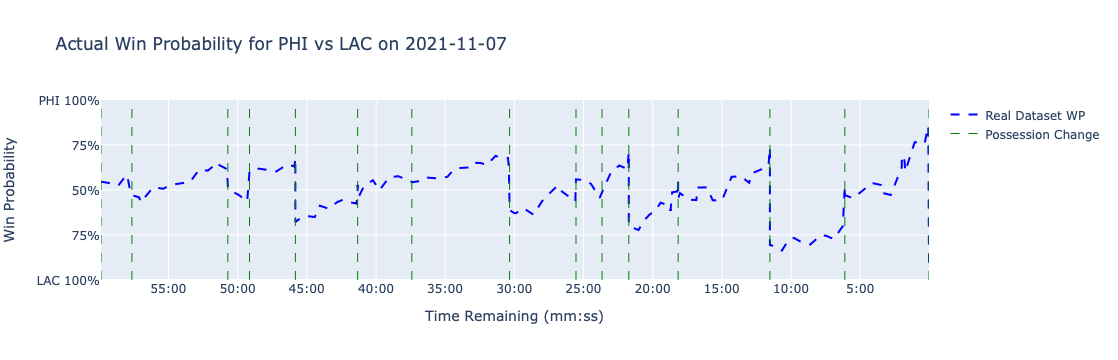

In [69]:
# plot the real dataset
fig_dataset = go.Figure()

# add real line from dataset
fig_dataset.add_trace(go.Scatter(
    x=time_remaining,
    y=game_df_sorted['wp'] * 100,
    mode='lines',
    name=f'Real Dataset WP',
    hovertext=[f"{home_team} Score: {hs}<br>{away_team} Score: {as_}<br>Dataset Win Probability: {wp:.2f}%<br>Time Remaining: {format_time_remaining(tr)}"
               for hs, as_, wp, tr in zip(game_df_sorted['home_team_score'], game_df_sorted['away_team_score'], transform_win_prob_for_display(game_df_sorted['wp']), time_remaining)],
    hoverinfo='text',
    line=dict(color='blue', width=2, dash='dash'),
))

# plot possession changes
possession_change_x = []
for possession_time in possession_change_times:
    possession_change_x.extend([possession_time, possession_time, None])

fig_dataset.add_trace(go.Scatter(
    x=possession_change_x,
    y=[0, 100, None] * len(possession_change_times),
    mode='lines',
    name='Possession Change',
    line=dict(color="green", width=1, dash="dash"),
    showlegend=True,
))


# generate x-axis tick values every 5 minutes (300 seconds)
total_seconds = int(game_df_sorted['game_seconds_remaining'].max())
tickvals = list(range(0, total_seconds + 1, 300))
ticktext = [format_time_remaining(seconds) for seconds in tickvals]


# update layout for dataset graph
fig_dataset.update_layout(
    title=f"Actual Win Probability for {home_team} vs {away_team} on {game_date}",
    xaxis_title="Time Remaining (mm:ss)",
    yaxis_title=f"Win Probability",
    yaxis=dict(
        range=[0, 100],
        tickvals=[0, 25, 50, 75, 100],
        ticktext=[f"{away_team} 100%", "75%", "50%", "75%", f"{home_team} 100%"],
    ),
    xaxis=dict(
        tickvals=tickvals,
        ticktext=ticktext,
        range=[total_seconds, 0],
        autorange="reversed",
    ),
    width=1000,
    hovermode='closest',
    showlegend=True,
)

fig_dataset.show()

This is looking quite similar to the graphs I'm used to seeing, albeit with a completely different GUI surrounding it. It's now easy to see why the addition of the possession changes is integral, as it has a large effect on the instantaneous win probability.

Now it's time to explain the features. In a perfect world, I'd be able to feed the model all of the data it could ever want, and it'd spit out a mirror image of the graph above. Unfortunately, the addition of each single feature increases the memory and time complexity of the computations exponentially. I'm running all of this locally on my 2020 MacBook, so it won't be able to handle much on its own.

As such, I'll explain each feature's purpose in the necessary quantity of detail. Feeding the model `quarter_seconds_remaining` provides some semblance of time pressure and the halftime possession change. Both `home_team_score` and `away_team_score` are quite intuitive, while the combination of `possession_status` and `game_seconds_remaining` has a little more nuance. There's a greater weight placed on the possessing team as the game continues, especially as you approach the end of the game. The last two features, `down` and `ydstogo` are pretty self-explanatory as well.

I later split the given data into training and testing data at a ratio of 80% training and 20% testing. The predictions are fed into my dataframe and the `mean_squared_error` is printed out. This is one of many quantitative representations of how close the predictions are to the given data. As an error closer to 0 is better, our value suggests that our predictions are incredibly accurate. To provide some background, I spent quite some time determining the features and hyperparameters (such as `max_depth`) based on the value of our `mse`.

In [42]:
# define our features
X = valid_df[['quarter_seconds_remaining', 'home_team_score', 'away_team_score', 'field_position', 'possession_status', 'game_seconds_remaining', 'down', 'ydstogo']]
y = valid_df['wp']

# remove NaN values
X = X.dropna()
y = y[X.index]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train model
model = RandomForestRegressor(max_depth=16, random_state=42)
model.fit(X_train, y_train)

# predict win probability for the random game
imputer = SimpleImputer(strategy='mean')
game_df_imputed = pd.DataFrame(imputer.fit_transform(game_df[['quarter_seconds_remaining', 'home_team_score', 'away_team_score', 'field_position', 'possession_status', 'game_seconds_remaining', 'down', 'ydstogo']]), 
                               columns=['quarter_seconds_remaining', 'home_team_score', 'away_team_score', 'field_position', 'possession_status', 'game_seconds_remaining', 'down', 'ydstogo'])

game_df['predicted_win_prob'] = model.predict(game_df_imputed)

# print mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0008525370320525121


We once again graph our data, opting for the model's predictions instead of the given `nfl_data_py` data. I also reuse the posessioon changes.

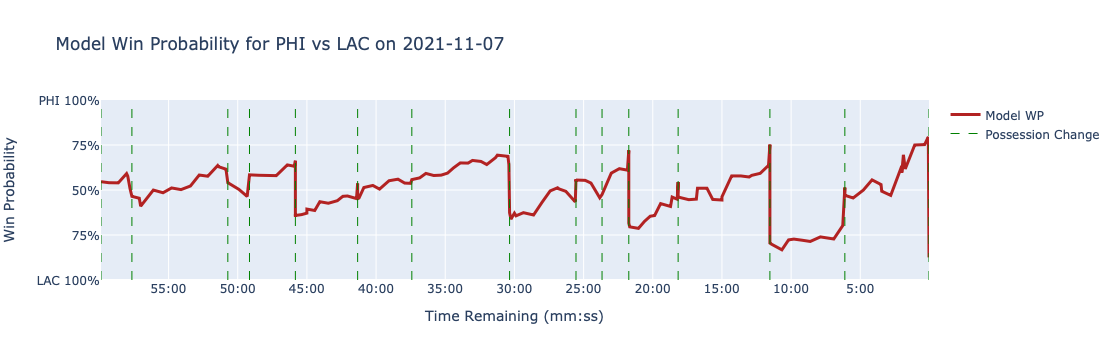

In [71]:
# predicted WP graph from the model
fig_model = go.Figure()

# predicted WP from the model
fig_model.add_trace(go.Scatter(
    x=time_remaining,
    y=game_df['predicted_win_prob'] * 100,
    mode='lines',
    name=f'Model WP',
    hovertext=[f"{home_team} Score: {hs}<br>{away_team} Score: {as_}<br>Win Probability: {wp:.2f}%<br>Time Remaining: {format_time_remaining(tr)}"
               for hs, as_, wp, tr in zip(game_df['home_team_score'], game_df['away_team_score'], transform_win_prob_for_display(game_df['predicted_win_prob']), time_remaining)],
    hoverinfo='text',
    line=dict(color='firebrick', width=3),
))

# add possession changes to the model graph
fig_model.add_trace(go.Scatter(
    x=possession_change_x,
    y=[0, 100, None] * len(possession_change_times),
    mode='lines',
    name='Possession Change',
    line=dict(color="green", width=1, dash="dash"),
    showlegend=True,
))

# update layout for the model graph
fig_model.update_layout(
    title=f"Model Win Probability for {home_team} vs {away_team} on {game_date}",
    xaxis_title="Time Remaining (mm:ss)",
    yaxis_title=f"Win Probability",
    yaxis=dict(
        range=[0, 100],
        tickvals=[0, 25, 50, 75, 100],
        ticktext=[f"{away_team} 100%", "75%", "50%", "75%", f"{home_team} 100%"]
    ),
    xaxis=dict(
        tickvals=tickvals,
        ticktext=ticktext,
        range=[total_seconds, 0],
        autorange="reversed",
    ),
    width=1000,
    hovermode='closest',
    showlegend=True,
)

fig_model.show()

Wow. Qualitatively, the model's output looks incredibly similar to the baseline graph. I had to scroll up and down a few times to make sure I didn't use the wrong dataset for the graphing, but I suppose that the small `mean_squared_error` value represented our output quite well. In order to see the small differences, I decided to plot both the dataset and model datapoints on the same graph.

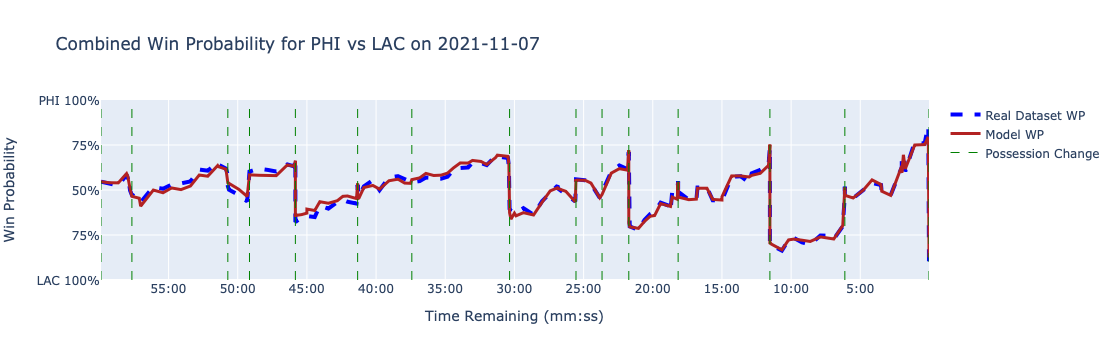

In [73]:
fig_combined = go.Figure()

# dataset line
fig_combined.add_trace(go.Scatter(
    x=time_remaining,
    y=game_df_sorted['wp'] * 100,
    mode='lines',
    hovertext=[f"Dataset Win Probability: {round(float(wp), 2)}%" for wp in dataset_wp_transformed],
    name=f'Real Dataset WP',
    hoverinfo='text',
    line=dict(color='blue', width=4, dash='dash'),
))

# predicted WP from the model
fig_combined.add_trace(go.Scatter(
    x=time_remaining,
    y=game_df['predicted_win_prob'] * 100,
    mode='lines',
    name=f'Model WP',
    hovertext=[f"{home_team} Score: {hs}<br>{away_team} Score: {as_}<br>Win Probability: {100*wp:.2f}%<br>Time Remaining: {format_time_remaining(tr)}"
               for hs, as_, wp, tr in zip(game_df['home_team_score'], game_df['away_team_score'], game_df['predicted_win_prob'], time_remaining)],
    hoverinfo='text',
    line=dict(color='firebrick', width=3),
))

# same possession change plot from before
fig_combined.add_trace(go.Scatter(
    x=possession_change_x,
    y=[0, 100, None] * len(possession_change_times),
    mode='lines',
    name='Possession Change',
    line=dict(color="green", width=1, dash="dash"),
    showlegend=True,
))

# update layout for combined plot
fig_combined.update_layout(
    title=f"Combined Win Probability for {home_team} vs {away_team} on {game_date}",
    xaxis_title="Time Remaining (mm:ss)",
    yaxis_title=f"Win Probability",
    yaxis=dict(
        range=[0, 100],
        tickvals=[0, 25, 50, 75, 100],
        ticktext=[f"{away_team} 100%", "75%", "50%", "75%", f"{home_team} 100%"],
    ),
    xaxis=dict(
        tickvals=tickvals,
        ticktext=ticktext,
        range=[total_seconds, 0],
        autorange="reversed",
    ),
    width=1000,
    hovermode='closest',
    showlegend=True,
)

# show the combined graph
fig_combined.show()

Indeed, the model worked its magic. While there are some points that aren't perfectly in line, it's clear that the features we chose tell a large part of the story. Any given NFL game will be unfathomably complex (in many unquantifiable ways), but it seems like these 8 quantitative figures can be more than enough. In the future, I wish to add historical records between teams as QBs as features, along with making these predictions in real time with ongoing game data. 